# Trompo simetrico y asimetrico, simulacion 3d.
- Juan Montoya
- Melanny Silva

Antes de desarrollar la teoria de las ecuaciones de euler, vamos a desarrollar los momentos de inercia y para eso debemos definir la geometria del trompo que vamos a usar. Para esto vamos a usar un modelo tres dimensional en formato stl.

In [29]:
# Vamos a graficar el modelo del trompo en 3D.
import numpy as np
import matplotlib.pyplot as plt
from stl import mesh
import numpy as np
import matplotlib.pyplot as plt
import sympy as smp
import matplotlib.tri as mtri
from scipy.integrate import solve_ivp


# Cargar el modelo STL del trompo simétrico
trompo_mesh = mesh.Mesh.from_file('trompo.stl')
vertices = trompo_mesh.vectors.reshape(-1, 3)

# Obtener el valor mínimo de Z (punto más bajo)
min_z = np.min(trompo_mesh.vectors[:, :, 2])

# Crear vector de traslación
traslacion = np.array([0, 0, -min_z])

# Aplicar traslación a todos los vértices
trompo_mesh.vectors += traslacion
# Vamos a redimensionar en x y en y
trompo_mesh.vectors[:, :, 0] *= 0.4
trompo_mesh.vectors[:, :, 1] *= 0.4

vertices = trompo_mesh.vectors.reshape(-1, 3)

# Mostrar información básica de la malla
print("Información del archivo STL:")
print(f"Número de triángulos: {len(trompo_mesh.vectors)}")
print(f"Número de puntos: {len(trompo_mesh.points)}")
print(f"Volumen de la malla: {trompo_mesh.get_mass_properties()[0]:.2f} unidades cúbicas")

# Definir masa uniforme para trompo simétrico
m_simetrico = np.ones(len(vertices))

# Definir masa no uniforme para trompo asimétrico
x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
m_asimetrico = z**3 * np.exp(x)


# Para trompo simétrico
x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
centro_masa_simetrico = np.array([
    np.sum(m_simetrico * x) / np.sum(m_simetrico),
    np.sum(m_simetrico * y) / np.sum(m_simetrico),
    np.sum(m_simetrico * z) / np.sum(m_simetrico)
])

# Para trompo asimétrico
centro_masa_asimetrico = np.array([
    np.sum(m_asimetrico * x) / np.sum(m_asimetrico),
    np.sum(m_asimetrico * y) / np.sum(m_asimetrico),
    np.sum(m_asimetrico * z) / np.sum(m_asimetrico)
])

# La altura h que necesitas para el lagrangiano es solo la componente z:
h_simetrico = centro_masa_simetrico[2]
h_asimetrico = centro_masa_asimetrico[2]

print(f"Altura del centro de masa (simétrico): {h_simetrico:.4f}")
print(f"Altura del centro de masa (asimétrico): {h_asimetrico:.4f}")

# Calcular caja envolvente
min_x, max_x = min(vertices[:, 0]), max(vertices[:, 0])
min_y, max_y = min(vertices[:, 1]), max(vertices[:, 1])
min_z, max_z = min(vertices[:, 2]), max(vertices[:, 2])
print("\nCaja envolvente:")
print(f"  Rango X: {min_x:.4f} a {max_x:.4f}, ancho: {max_x - min_x:.4f}")
print(f"  Rango Y: {min_y:.4f} a {max_y:.4f}, ancho: {max_y - min_y:.4f}")
print(f"  Rango Z: {min_z:.4f} a {max_z:.4f}, altura: {max_z - min_z:.4f}")



def calcular_inercia_personalizada(vertices, masas):
    # Normalizar las masas para mantener masa total similar
    masas_norm = masas / np.sum(masas) * len(masas)

    # Calcular los componentes de la matriz de inercia
    Ixx = np.sum(masas_norm * (vertices[:, 1]**2 + vertices[:, 2]**2))
    Iyy = np.sum(masas_norm * (vertices[:, 0]**2 + vertices[:, 2]**2))
    Izz = np.sum(masas_norm * (vertices[:, 0]**2 + vertices[:, 1]**2))
    Ixy = -np.sum(masas_norm * vertices[:, 0] * vertices[:, 1])
    Iyz = -np.sum(masas_norm * vertices[:, 1] * vertices[:, 2])
    Ixz = -np.sum(masas_norm * vertices[:, 0] * vertices[:, 2])
    
    return np.array([
        [Ixx, Ixy, Ixz],
        [Ixy, Iyy, Iyz],
        [Ixz, Iyz, Izz]
    ])


Información del archivo STL:
Número de triángulos: 3028
Número de puntos: 3028
Volumen de la malla: 465.25 unidades cúbicas
Altura del centro de masa (simétrico): 10.6079
Altura del centro de masa (asimétrico): 13.4905

Caja envolvente:
  Rango X: -5.7148 a 5.7148, ancho: 11.4296
  Rango Y: -5.7100 a 5.7100, ancho: 11.4200
  Rango Z: 0.0000 a 32.8500, altura: 32.8500


Matriz de Inercia - Trompo Simétrico:
[[ 1.43103741e+06 -1.42988702e-01  1.09139364e-11]
 [-1.42988702e-01  1.43103741e+06 -0.00000000e+00]
 [ 1.09139364e-11 -0.00000000e+00  9.45644128e+04]]

Momentos principales de inercia (simétrico):
Ixx = 1.4e+06
Iyy = 1.4e+06
Izz = 9.5e+04

Matriz de Inercia - Trompo Asimétrico:
[[ 1.8371116e+06 -2.6613476e+01 -4.9131584e+05]
 [-2.6613476e+01  1.9920616e+06 -4.6071289e+01]
 [-4.9131584e+05 -4.6071289e+01  2.3334895e+05]]

Momentos principales de inercia (asimétrico):
Ixx = 1.8e+06
Iyy = 2e+06
Izz = 2.3e+05


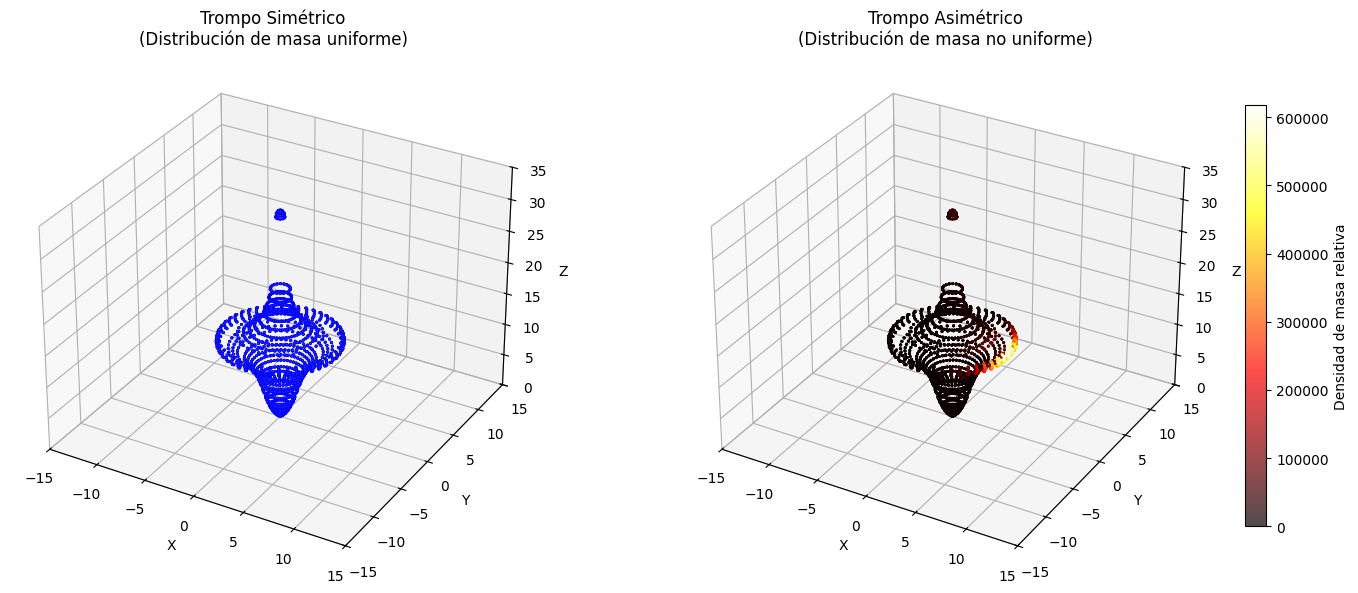

In [30]:
# Calcular matrices de inercia para ambos casos
I_simetrico = calcular_inercia_personalizada(vertices, m_simetrico)
I_asimetrico = calcular_inercia_personalizada(vertices, m_asimetrico)
I_simetrico[1,1] = I_simetrico[0,0] 

print("Matriz de Inercia - Trompo Simétrico:")
print(I_simetrico)
print(f"\nMomentos principales de inercia (simétrico):")
print(f"Ixx = {I_simetrico[0,0]:.2g}")
print(f"Iyy = {I_simetrico[1,1]:.2g}")
print(f"Izz = {I_simetrico[2,2]:.2g}")

print("\n" + "="*50)
print("Matriz de Inercia - Trompo Asimétrico:")
print(I_asimetrico)
print(f"\nMomentos principales de inercia (asimétrico):")
print(f"Ixx = {I_asimetrico[0,0]:.2g}")
print(f"Iyy = {I_asimetrico[1,1]:.2g}")
print(f"Izz = {I_asimetrico[2,2]:.2g}")


fig = plt.figure(figsize=(15, 6))

# Subplot 1: Trompo con distribución de masa simétrica
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(vertices[:,0], vertices[:,1], vertices[:,2], 
            color='lightblue', alpha=0.7, edgecolor='b', s=1.2)
ax1.set_xlim([-15, 15])
ax1.set_ylim([-15, 15])
ax1.set_zlim([0, 35])
ax1.set_title('Trompo Simétrico\n(Distribución de masa uniforme)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Subplot 2: Trompo con distribución de masa asimétrica
ax2 = fig.add_subplot(122, projection='3d')
scatter = ax2.scatter(vertices[:,0], vertices[:,1], vertices[:,2], 
                     c=m_asimetrico, cmap='hot', s=1.2, alpha=0.7)
ax2.set_title('Trompo Asimétrico\n(Distribución de masa no uniforme)')
ax2.set_xlim([-15, 15])
ax2.set_ylim([-15, 15])
ax2.set_zlim([0, 35])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.colorbar(scatter, ax=ax2, shrink=0.8, label='Densidad de masa relativa')

plt.tight_layout()
plt.show()


Teniendo bien descritos nuemtros trompos definidos, podemos continuar con las ecuaciones de movimiento. Sabemos que el vector $\omega$ con la convencion de angulos de euler ZX'Z'' es:
$$\vec{\omega} = \begin{bmatrix}\dot{\phi}\sin(\theta)\sin(\psi) + \dot{\theta}\cos(\psi)\\\dot{\phi}\sin(\theta)\cos(\psi) - \dot{\theta}\sin(\psi)\\ \dot{\phi}\cos(\theta) + \dot{\psi} \end{bmatrix}$$

Ademas, de forma matricial la energia cinetica es:
$$
T = \frac{1}{2}\omega^{T}I\omega 
$$

Donde $I$ es el tensor de momentos de inercia. Por la parte de la energia potencial que en el centro de masa esta dada por $V = mgh\cos(\theta)$, donde $h$ es la altura del centro de masa. En otras palabras el lagrangiano es:
$$
L = \frac{1}{2}\omega^{T}I\omega - mgh\cos(\theta)
$$


In [31]:
# Hacemos uso de sympy para definir las variables simbólicas y las funciones de ángulo, así mismo con sus derivadas.

t = smp.symbols('t', real=True)
theta, phi, psi = smp.symbols(r'\theta \phi \psi', cls=smp.Function)
g = 9.81  # Aceleración gravitacional
h = 12
theta = theta(t)
phi = phi(t)
psi = psi(t)
# Derivadas
dtheta = smp.diff(theta, t)
dphi = smp.diff(phi, t)
dpsi = smp.diff(psi, t)

# Segundas derivadas
ddtheta = smp.diff(dtheta, t)
ddphi = smp.diff(dphi, t)
ddpsi = smp.diff(dpsi, t)

# Definimos la matriz de transformacion de los angulos de euler.
R3 = smp.Matrix([[smp.cos(psi),-smp.sin(psi),0],
                 [smp.sin(psi),smp.cos(psi),0],
                 [0,0,1]])

R2 = smp.Matrix([[1,0,0],
                 [0,smp.cos(theta),-smp.sin(theta)],
                 [0,smp.sin(theta),smp.cos(theta)]])

R1 = smp.Matrix([[smp.cos(phi),-smp.sin(phi),0],
                 [smp.sin(phi),smp.cos(phi),0],
                 [0,0,1]])

R = R1*R2*R3


In [32]:
R@smp.Matrix([0,0,1])

Matrix([
[ sin(\phi(t))*sin(\theta(t))],
[-sin(\theta(t))*cos(\phi(t))],
[              cos(\theta(t))]])

Ahora escribimos con sympy el vector $\omega$ ya definido antes

In [33]:
omega = smp.Matrix([dphi*smp.sin(theta)*smp.sin(psi)+dtheta*smp.cos(psi),
                    dphi*smp.sin(theta)*smp.cos(psi)-dtheta*smp.sin(psi), 
                    dphi*smp.cos(theta)+dpsi])
omega

Matrix([
[ sin(\psi(t))*sin(\theta(t))*Derivative(\phi(t), t) + cos(\psi(t))*Derivative(\theta(t), t)],
[-sin(\psi(t))*Derivative(\theta(t), t) + sin(\theta(t))*cos(\psi(t))*Derivative(\phi(t), t)],
[                             cos(\theta(t))*Derivative(\phi(t), t) + Derivative(\psi(t), t)]])

Ahora definimos el tensor de momentos de inercia $I$

In [34]:
Ixx, Iyy, Izz = smp.symbols('I_{xx}, I_{yy}, I_{zz}', real=True)
I = smp.Matrix([[Ixx,0,0],[0,Iyy,0],[0,0,Izz]])
I

Matrix([
[I_{xx},      0,      0],
[     0, I_{yy},      0],
[     0,      0, I_{zz}]])

Definimos el lagrangiano $L$:

In [35]:
T = smp.Rational(1,2) * omega.T.dot(I*omega).simplify()
V = g * h * smp.cos(theta)
L = T - V

Ahora podemos derivar las ecuaciones de movimiento de euler lagrange, donde las $q_i$ son los angulos $\theta$, $\phi$ y $\psi$:
$$
\frac{d}{dt}\frac{\partial L}{\partial \dot{q_i}} - \frac{\partial L}{\partial q_i} = 0
$$

In [36]:
# Para el trompo simétrico
Ixx_sim = I_simetrico[0,0]
Iyy_sim = I_simetrico[0,0] 
Izz_sim = I_simetrico[2,2]
h_sim = h_simetrico

# Para el trompo asimétrico
Ixx_asim = I_asimetrico[0,0]
Iyy_asim = I_asimetrico[1,1] 
Izz_asim = I_asimetrico[2,2]
h_asim = h_asimetrico


In [37]:
el_th = smp.diff(smp.diff(L, dtheta), t) - smp.diff(L, theta)
eq_th = (Ixx_sim * ddtheta - Ixx_sim * dphi**2 * smp.sin(theta) * smp.cos(theta) + Izz_sim * dphi * dpsi * smp.sin(theta) - g * h_sim * smp.sin(theta))
el_th = el_th.simplify()

el_ph = smp.diff(smp.diff(L, dphi), t) - smp.diff(L, phi)
eq_ph = (Ixx_sim * smp.sin(theta)**2 * ddphi + 2 * Ixx_sim * smp.sin(theta) * smp.cos(theta) * dphi * dtheta + Izz_sim * smp.sin(theta) * dtheta * dpsi)
el_ph = el_ph.simplify()

el_ps = smp.diff(smp.diff(L, dpsi), t) - smp.diff(L, psi)
eq_ps = ddpsi + ddphi * smp.cos(theta) - dphi * dtheta * smp.sin(theta)
el_ps = el_ps.simplify()

In [38]:
# Resolver para las aceleraciones angulares
print("Resolviendo para las aceleraciones angulares...")

# Resolver el sistema de ecuaciones
sol_accel = smp.solve([eq_th, eq_ph, eq_ps], 
                        [ddtheta, ddphi, ddpsi], 
                        simplify=False, rational=False)

f_ddtheta = sol_accel[ddtheta]
f_ddphi = sol_accel[ddphi]
f_ddpsi = sol_accel[ddpsi]
    

Resolviendo para las aceleraciones angulares...


In [39]:
# Convertir a funciones numéricas para la integración
# Variables para lambdify
vars_list = [theta, phi, psi, dtheta, dphi, dpsi]

# Convertir las expresiones simbólicas a funciones numéricas
dtheta_ddot_dt = smp.lambdify(vars_list, f_ddtheta, 'numpy')
dphi_ddot_dt = smp.lambdify(vars_list, f_ddphi, 'numpy')
dpsi_ddot_dt = smp.lambdify(vars_list, f_ddpsi, 'numpy')


In [40]:
def sistema_ecuaciones(t, s):
    """
    Sistema de ecuaciones diferenciales de primer orden para el trompo simétrico.
    
    Variables de estado:
    s = [theta, theta_dot, phi, phi_dot, psi, psi_dot]
    
    Retorna:
    ds/dt = [theta_dot, theta_ddot, phi_dot, phi_ddot, psi_dot, psi_ddot]
    """
    theta_val, theta_dot_val, phi_val, phi_dot_val, psi_val, psi_dot_val = s
    
    # Calcular las aceleraciones angulares
    try:
        theta_ddot_val = dtheta_ddot_dt(theta_val, phi_val, psi_val, 
                                       theta_dot_val, phi_dot_val, psi_dot_val)
        phi_ddot_val = dphi_ddot_dt(theta_val, phi_val, psi_val, 
                                   theta_dot_val, phi_dot_val, psi_dot_val)
        psi_ddot_val = dpsi_ddot_dt(theta_val, phi_val, psi_val, 
                                   theta_dot_val, phi_dot_val, psi_dot_val)
    except:
        # Valores de emergencia si hay problemas numéricos
        theta_ddot_val = 0.0
        phi_ddot_val = 0.0  
        psi_ddot_val = 0.0
    
    return [
        theta_dot_val,    # d(theta)/dt
        theta_ddot_val,   # d(theta_dot)/dt
        phi_dot_val,      # d(phi)/dt
        phi_ddot_val,     # d(phi_dot)/dt
        psi_dot_val,      # d(psi)/dt
        psi_ddot_val      # d(psi_dot)/dt
    ]


In [41]:
# Condiciones iniciales
theta_0 = np.pi/8        # Ángulo inicial de nutación (30 grados)
theta_dot_0 = 0.0        # Velocidad angular inicial de nutación
phi_0 = 0.0              # Ángulo inicial de precesión
phi_dot_0 = 10.0          # Velocidad angular inicial de precesión (rad/s)
psi_0 = 0.0              # Ángulo inicial de rotación propia
psi_dot_0 = 100*np.pi         # Velocidad angular inicial de rotación propia (rad/s)

# Vector de condiciones iniciales
s0 = [theta_0, theta_dot_0, phi_0, phi_dot_0, psi_0, psi_dot_0]

# Parámetros de tiempo
t_final = 2.0            # Tiempo final de simulación (s)
n_puntos = 2000          # Número de puntos de tiempo
t_span = (0, t_final)
t_eval = np.linspace(0, t_final, n_puntos)

print(f"Condiciones iniciales:")
print(f"θ₀ = {np.degrees(theta_0):.1f}° ({theta_0:.3f} rad)")
print(f"θ̇₀ = {theta_dot_0:.1f} rad/s")
print(f"φ₀ = {np.degrees(phi_0):.1f}° ({phi_0:.3f} rad)")
print(f"φ̇₀ = {phi_dot_0:.1f} rad/s")
print(f"ψ₀ = {np.degrees(psi_0):.1f}° ({psi_0:.3f} rad)")
print(f"ψ̇₀ = {psi_dot_0:.1f} rad/s")
print(f"\nSimulación: {t_final} s con {n_puntos} puntos")

Condiciones iniciales:
θ₀ = 22.5° (0.393 rad)
θ̇₀ = 0.0 rad/s
φ₀ = 0.0° (0.000 rad)
φ̇₀ = 10.0 rad/s
ψ₀ = 0.0° (0.000 rad)
ψ̇₀ = 314.2 rad/s

Simulación: 2.0 s con 2000 puntos


In [42]:
# Resolver el sistema de ecuaciones diferenciales
print("Iniciando integración numérica...")
print("Esto puede tomar unos segundos...")

# Resolver usando el método RK45 (Runge-Kutta de 4º-5º orden)
sol = solve_ivp(sistema_ecuaciones, t_span, s0, t_eval=t_eval, 
                method='RK45', rtol=1e-8, atol=1e-10)

if sol.success:
    print("✓ Integración completada exitosamente")
    print(f"Puntos calculados: {len(sol.t)}")
    print(f"Tiempo final alcanzado: {sol.t[-1]:.3f} s")
else:
    print("✗ Error en la integración:")
    print(sol.message)

# Extraer las soluciones
t_solucion = sol.t
theta_sol = sol.y[0]
theta_dot_sol = sol.y[1]
phi_sol = sol.y[2]
phi_dot_sol = sol.y[3]
psi_sol = sol.y[4]
psi_dot_sol = sol.y[5]

print(f"\nRangos de los ángulos:")
print(f"θ: {np.degrees(theta_sol.min()):.1f}° a {np.degrees(theta_sol.max()):.1f}°")
print(f"φ: {np.degrees(phi_sol.min()):.1f}° a {np.degrees(phi_sol.max()):.1f}°")
print(f"ψ: {np.degrees(psi_sol.min()):.1f}° a {np.degrees(psi_sol.max()):.1f}°")

Iniciando integración numérica...
Esto puede tomar unos segundos...
✓ Integración completada exitosamente
Puntos calculados: 2000
Tiempo final alcanzado: 2.000 s

Rangos de los ángulos:
θ: 15.2° a 22.5°
φ: 0.0° a 2134.5°
ψ: 0.0° a 35033.2°


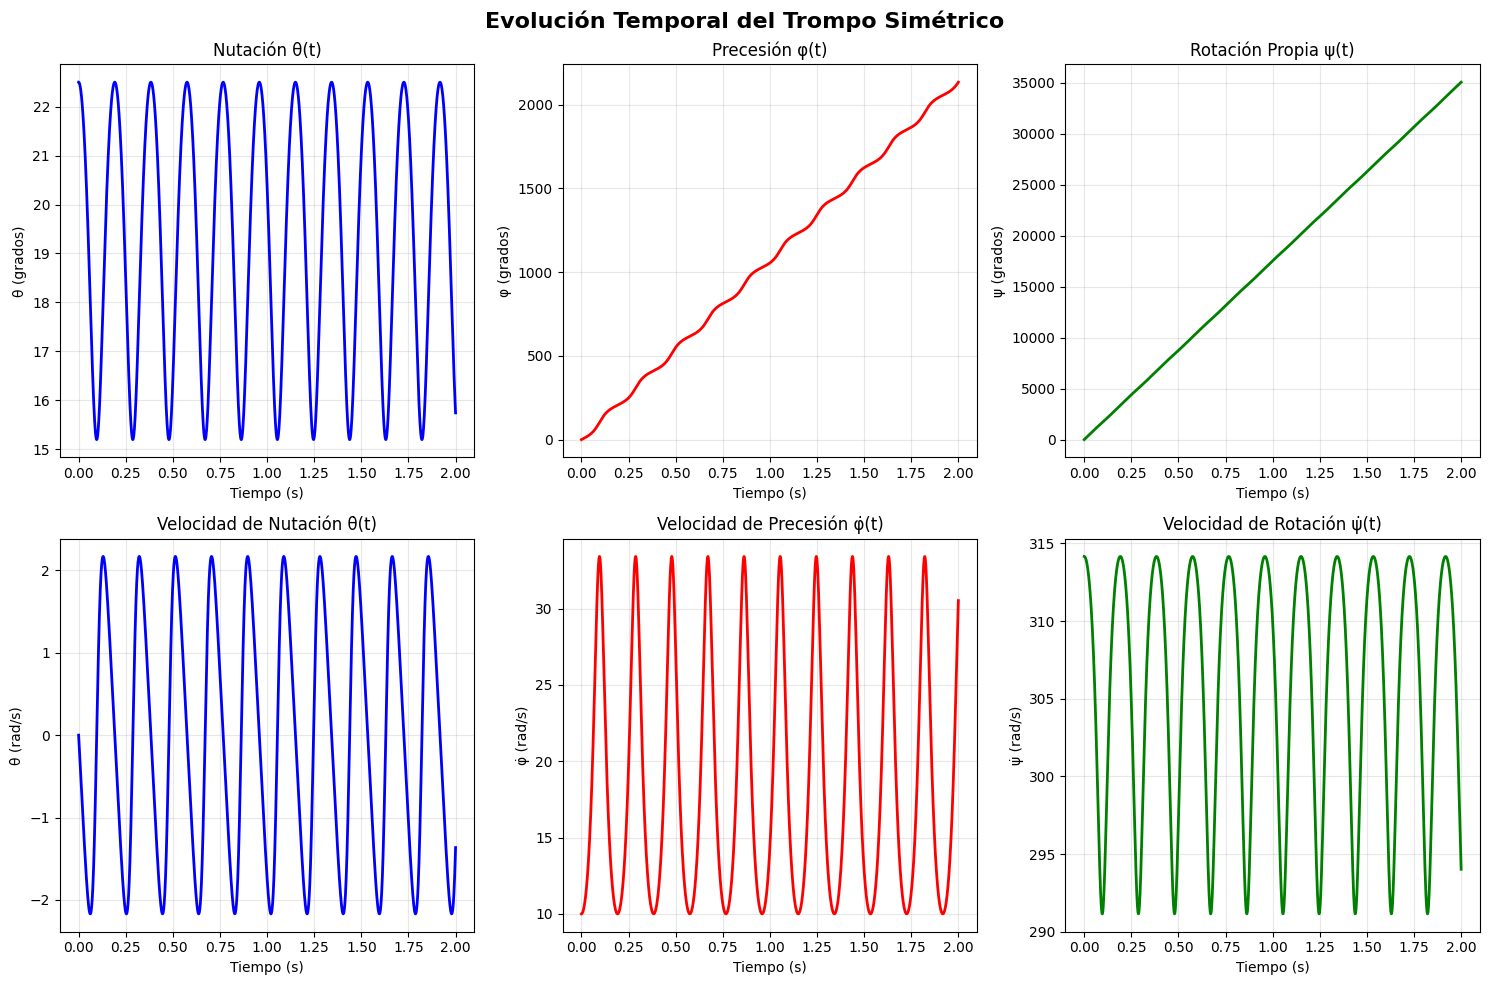

In [43]:
# Gráfico de la evolución temporal de los ángulos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Evolución Temporal del Trompo Simétrico', fontsize=16, fontweight='bold')

# Ángulos
axes[0,0].plot(t_solucion, np.degrees(theta_sol), 'b-', linewidth=2)
axes[0,0].set_title('Nutación θ(t)')
axes[0,0].set_xlabel('Tiempo (s)')
axes[0,0].set_ylabel('θ (grados)')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(t_solucion, np.degrees(phi_sol), 'r-', linewidth=2)
axes[0,1].set_title('Precesión φ(t)')
axes[0,1].set_xlabel('Tiempo (s)')
axes[0,1].set_ylabel('φ (grados)')
axes[0,1].grid(True, alpha=0.3)

axes[0,2].plot(t_solucion, np.degrees(psi_sol), 'g-', linewidth=2)
axes[0,2].set_title('Rotación Propia ψ(t)')
axes[0,2].set_xlabel('Tiempo (s)')
axes[0,2].set_ylabel('ψ (grados)')
axes[0,2].grid(True, alpha=0.3)

# Velocidades angulares
axes[1,0].plot(t_solucion, theta_dot_sol, 'b-', linewidth=2)
axes[1,0].set_title('Velocidad de Nutación θ̇(t)')
axes[1,0].set_xlabel('Tiempo (s)')
axes[1,0].set_ylabel('θ̇ (rad/s)')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(t_solucion, phi_dot_sol, 'r-', linewidth=2)
axes[1,1].set_title('Velocidad de Precesión φ̇(t)')
axes[1,1].set_xlabel('Tiempo (s)')
axes[1,1].set_ylabel('φ̇ (rad/s)')
axes[1,1].grid(True, alpha=0.3)

axes[1,2].plot(t_solucion, psi_dot_sol, 'g-', linewidth=2)
axes[1,2].set_title('Velocidad de Rotación ψ̇(t)')
axes[1,2].set_xlabel('Tiempo (s)')
axes[1,2].set_ylabel('ψ̇ (rad/s)')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

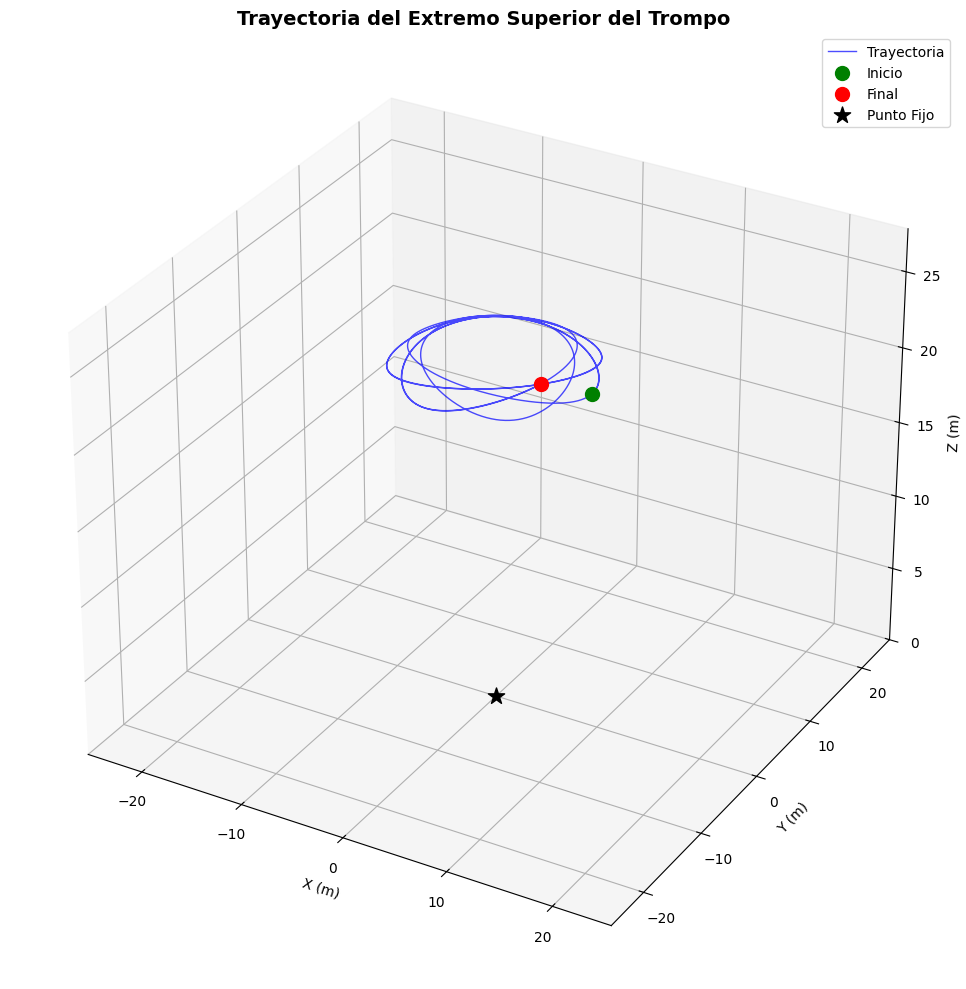

Trayectoria calculada para 2000 puntos
Rango X: -8.7514 a 9.1844 m
Rango Y: -9.0625 a 9.0721 m
Rango Z: 22.1731 a 23.1610 m


In [44]:
# Función para calcular la posición del extremo superior del trompo
def calcular_posicion_extremo(theta, phi, psi, L):
    """
    Calcula la posición del extremo superior del trompo usando los ángulos de Euler.
    
    Parámetros:
    theta, phi, psi: ángulos de Euler (radianes)
    L: longitud del trompo (distancia del punto fijo al extremo)
    
    Retorna:
    x, y, z: coordenadas cartesianas del extremo
    """
    x = 2*L * np.sin(theta) * np.cos(phi)
    y = 2*L * np.sin(theta) * np.sin(phi) 
    z = 2*L * np.cos(theta)
    return x, y, z

# Calcular la trayectoria del extremo superior
L_trompo = h  # Usamos la distancia al centro de masa como longitud característica
x_extremo, y_extremo, z_extremo = calcular_posicion_extremo(theta_sol, phi_sol, psi_sol, L_trompo)

# Gráfico 3D de la trayectoria
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Trayectoria completa
ax.plot(x_extremo, y_extremo, z_extremo, 'b-', linewidth=1, alpha=0.7, label='Trayectoria')

# Punto inicial y final
ax.scatter([x_extremo[0]], [y_extremo[0]], [z_extremo[0]], 
          color='green', s=100, label='Inicio')
ax.scatter([x_extremo[-1]], [y_extremo[-1]], [z_extremo[-1]], 
          color='red', s=100, label='Final')

# Punto fijo (origen)
ax.scatter([0], [0], [0], color='black', s=150, marker='*', label='Punto Fijo')

# Configuración de ejes
max_range = max(np.max(np.abs(x_extremo)), np.max(np.abs(y_extremo)), np.max(z_extremo))
ax.set_xlim(-max_range*1.1, max_range*1.1)
ax.set_ylim(-max_range*1.1, max_range*1.1)
ax.set_zlim(0, max_range*1.2)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Trayectoria del Extremo Superior del Trompo', fontsize=14, fontweight='bold')
ax.legend()

# Establecer aspecto igual
ax.set_box_aspect([1,1,0.8])

plt.tight_layout()
plt.show()

print(f"Trayectoria calculada para {len(t_solucion)} puntos")
print(f"Rango X: {x_extremo.min():.4f} a {x_extremo.max():.4f} m")
print(f"Rango Y: {y_extremo.min():.4f} a {y_extremo.max():.4f} m")
print(f"Rango Z: {z_extremo.min():.4f} a {z_extremo.max():.4f} m")

In [45]:
def rotate_stl_mesh(mesh, theta, phi, psi):    
    # Matriz de rotación ZXZ
    R = np.array([
        [np.cos(phi)*np.cos(psi) - np.sin(phi)*np.cos(theta)*np.sin(psi), 
         -np.cos(phi)*np.sin(psi) - np.sin(phi)*np.cos(theta)*np.cos(psi), 
         np.sin(phi)*np.sin(theta)],
        [np.sin(phi)*np.cos(psi) + np.cos(phi)*np.cos(theta)*np.sin(psi), 
         -np.sin(phi)*np.sin(psi) + np.cos(phi)*np.cos(theta)*np.cos(psi), 
         -np.cos(phi)*np.sin(theta)],
        [np.sin(theta)*np.sin(psi), np.sin(theta)*np.cos(psi), np.cos(theta)]
    ])
    
    # Copiar los vértices y rotarlos
    vertices = mesh.vectors.copy().reshape(-1, 3)
    vertices_rotados = np.dot(vertices, R.T)
    return vertices_rotados.reshape(mesh.vectors.shape)

from matplotlib.animation import FuncAnimation

# Configurar figura
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
limite = h_simetrico * 1.5  # Límite basado en la altura del centro de masa

def init_animacion():
    """Inicializa la animación"""
    ax.clear()
    ax.set_xlim(-limite, limite)
    ax.set_ylim(-limite, limite)
    ax.set_zlim(0, limite*2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return []

def actualizar_frame(i):
    """Actualiza cada frame"""
    ax.clear()
    ax.set_xlim(-limite, limite)
    ax.set_ylim(-limite, limite)
    ax.set_zlim(0, limite*2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Trompo simetrico \n t = {t_solucion[i]:.2f} s')

    # Punto fijo
    ax.scatter([0], [0], [0], color='red', s=110, marker='*', label='Punto Fijo')

    # Dibujar la trayectoria hasta el punto actual (nuevo)
    indice_actual = frames_animacion[i//20] if i//20 < len(frames_animacion) else -1
    ax.plot(x_extremo[indice_actual-60:indice_actual+1], y_extremo[indice_actual-60:indice_actual+1], z_extremo[indice_actual-60:indice_actual+1], 
           'b-', linewidth=1.5, label='Trayectoria')
    
    # Destacar posición actual del extremo (nuevo)
    ax.scatter([x_extremo[indice_actual]], [y_extremo[indice_actual]], [z_extremo[indice_actual]], 
              color='green', s=50)

    # Rotar modelo STL
    vertices_rotados = rotate_stl_mesh(trompo_mesh, theta_sol[i], phi_sol[i], psi_sol[i])
    x, y, z = vertices_rotados.reshape(-1, 3).T
    # Usar triangulación simple
    triangles = np.arange(len(x)).reshape(-1, 3)[:len(x)//3]
    tri = mtri.Triangulation(x, y, triangles=triangles)
    ax.plot_trisurf(tri, z, cmap='viridis', alpha=0.8, linewidth=0.1, 
                antialiased=True, shade=True)
    
    ax.legend(loc='upper right')

    return []

# Crear animación
frames_animacion = np.arange(0, len(t_solucion), 20)  # Cada 20 frame
anim = FuncAnimation(fig, actualizar_frame, frames=frames_animacion,
                     init_func=init_animacion, blit=False, interval=100)

# Guardar animación
print("Guardando animación...")
anim.save('trompo1.mp4', writer='ffmpeg', fps=10, extra_args=['-vcodec', 'libx264'])
print("✓ Animación guardada como 'trompo1.mp4'")
plt.close()

Guardando animación...
✓ Animación guardada como 'trompo1.mp4'


## La peonza asimétrica según Landau
### Asi lo hace el landau pero en nuestro caso, $I_2 > I_1 > I_3$
Para una peonza asimétrica, donde los momentos de inercia satisfacen $I_3 > I_2 > I_1$, existen dos integrales de movimiento fundamentales derivadas de las ecuaciones de Euler:

1. Conservación de la energía:
   $$\frac{M_1^2}{I_1} + \frac{M_2^2}{I_2} + \frac{M_3^2}{I_3} = 2E$$

2. Conservación del momento angular:
   $$M_1^2 + M_2^2 + M_3^2 = M^2$$

Geométricamente, estas ecuaciones representan:
- La primera, un elipsoide de semiejes $\sqrt{2EI_1}$, $\sqrt{2EI_2}$, $\sqrt{2EI_3}$
- La segunda, una esfera de radio $M$

El vector momento angular $\mathbf{M}$ se mueve a lo largo de la intersección de estas dos superficies. Esta intersección existe cuando se cumple:
$$2EI_1 < M^2 < 2EI_3$$

Esta condición garantiza que el radio de la esfera está entre el semieje menor y el mayor del elipsoide.

In [46]:
import plotly.graph_objects as go
import numpy as np


omega = np.array([1.0e-7, 0, 1.0e-5])  # Velocidades angulares en rad/s
I1 = 1.8e+06   # Momento de inercia en x (el menor)
I2 = 2e+06   # Momento de inercia en y (intermedio)
I3 = 2.3e+05   # Momento de inercia en z (el mayor)  # Energía (ajustar según sea necesario)
M1 = I1*omega[0]   # Momento angular en x
M2 = I2*omega[1]   # Momento angular en y
M3 = I3*omega[2]   # Momento angular en z
M = M1**2 + M2**2 + M3**2  # Masa total del trompo asimétrico
E = (M1**2 / I1) + (M2**2 / I2) + (M3**2 / I3)

# Verificar condición de existencia de la intersección
condition = f"Condición de intersección: 2*E*I2 > M^2 > 2*E*I3"
result = f"{2*E*I2:.2g} > {M**2:.2g} > {2*E*I3:.2g}"
valid = (2*E*I2 > M**2 > 2*E*I3)
print(condition)
print(result)

# Calcular semiejes del elipsoide
a = np.sqrt(2*E*I1)  # Semieje en x
b = np.sqrt(2*E*I2)  # Semieje en y
c = np.sqrt(2*E*I3)  # Semieje en z
r = M  # Radio de la esfera

# Generar puntos para el elipsoide
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = a * np.outer(np.cos(u), np.sin(v))
y = b * np.outer(np.sin(u), np.sin(v))
z = c * np.outer(np.ones_like(u), np.cos(v))

# Generar puntos para la esfera
x_sphere = r * np.outer(np.cos(u), np.sin(v))
y_sphere = r * np.outer(np.sin(u), np.sin(v))
z_sphere = r * np.outer(np.ones_like(u), np.cos(v))

# Generar puntos para la intersección
def intersection_curve(u, num_points=200):
    # Parametrización de la curva de intersección
    points = []
    for theta in np.linspace(0, 2*np.pi, num_points):
        # Resolver para encontrar r en coordenadas esféricas
        phi_values = np.linspace(0, np.pi, 100)
        for phi in phi_values:
            x = r * np.sin(phi) * np.cos(theta)
            y = r * np.sin(phi) * np.sin(theta)
            z = r * np.cos(phi)
            
            # Verificar si el punto está aproximadamente en el elipsoide
            ellipsoid_eq = (x/a)**2 + (y/b)**2 + (z/c)**2
            if abs(ellipsoid_eq - 1.0) < 0.035:
                points.append([x, y, z])
    
    return np.array(points)

# Calcular puntos de intersección
intersection_points = intersection_curve(u)

# Crear figura con Plotly
fig = go.Figure()

# Añadir el elipsoide
fig.add_trace(go.Surface(
    x=x, y=y, z=z,
    colorscale='Blues',
    opacity=0.5,
    showscale=False,
    name='Elipsoide: $\\frac{M_1^2}{I_1}+\\frac{M_2^2}{I_2}+\\frac{M_3^2}{I_3}=2E$'
))

# Añadir la esfera
fig.add_trace(go.Surface(
    x=x_sphere, y=y_sphere, z=z_sphere,
    colorscale='Reds',
    opacity=0.5,
    showscale=False,
    name='Esfera: $M_1^2+M_2^2+M_3^2=M^2$'
))

# Añadir la intersección si hay puntos
if len(intersection_points) > 0:
    fig.add_trace(go.Scatter3d(
        x=intersection_points[:, 0],
        y=intersection_points[:, 1],
        z=intersection_points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='green',
        ),
        name='Intersección (trayectoria de M)'
    ))

# Configurar el layout
max_range = max(a, b, c, r) * 1.2
fig.update_layout(
    title='Geometría del movimiento de la peonza asimétrica',
    scene=dict(
        xaxis_title='$M_1$',
        yaxis_title='$M_2$',
        zaxis_title='$M_3$',
        aspectmode='cube',
        xaxis=dict(range=[-max_range, max_range]),
        yaxis=dict(range=[-max_range, max_range]),
        zaxis=dict(range=[-max_range, max_range])
    ),
    width=600,
    height=500,
    legend=dict(
        x=0.7,
        y=0.1,
    )
)

fig.show()

Condición de intersección: 2*E*I2 > M^2 > 2*E*I3
92 > 28 > 11


In [47]:
import plotly.graph_objects as go
import numpy as np

omega = np.array([1.0e-7, 0, 1.0e-5])  # Velocidades angulares en rad/s
I1 = 1.8e+06   # Momento de inercia en x (el menor)
I2 = 2e+06     # Momento de inercia en y (intermedio)
I3 = 2.3e+05   # Momento de inercia en z (el mayor)
M1 = I1*omega[0]   # Momento angular en x
M2 = I2*omega[1]   # Momento angular en y
M3 = I3*omega[2]   # Momento angular en z
M_squared = M1**2 + M2**2 + M3**2  # Cuadrado del momento angular total
M = np.sqrt(M_squared)  # Momento angular total (radio de la esfera)
E = (M1**2 / I1) + (M2**2 / I2) + (M3**2 / I3) / 2  # Energía cinética

# Verificar condición de existencia de la intersección
condition = f"Condición de intersección: 2*E*I2 > M^2 > 2*E*I3"
result = f"{2*E*I2:.2g} > {M_squared:.2g} > {2*E*I3:.2g}"
valid = (2*E*I2 > M_squared > 2*E*I3)
print(condition)
print(result)
print(f"¿Condición satisfecha? {'Sí' if valid else 'No'}")

# Calcular semiejes del elipsoide
a = np.sqrt(2*E*I1)  # Semieje en x
b = np.sqrt(2*E*I2)  # Semieje en y
c = np.sqrt(2*E*I3)  # Semieje en z
r = np.sqrt(M_squared)  # Radio de la esfera

print(f"\nSemiejes del elipsoide:")
print(f"a = √(2EI₁) = {a:.4g}")
print(f"b = √(2EI₂) = {b:.4g}")
print(f"c = √(2EI₃) = {c:.4g}")
print(f"Radio de la esfera: r = M = {r:.4g}")

# Generar puntos para el elipsoide
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = a * np.outer(np.cos(u), np.sin(v))
y = b * np.outer(np.sin(u), np.sin(v))
z = c * np.outer(np.ones_like(u), np.cos(v))

# Generar puntos para la esfera
x_sphere = r * np.outer(np.cos(u), np.sin(v))
y_sphere = r * np.outer(np.sin(u), np.sin(v))
z_sphere = r * np.outer(np.ones_like(u), np.cos(v))

# Generar puntos para la intersección
def intersection_curve(u, num_points=200):
    # Parametrización de la curva de intersección
    points = []
    for theta in np.linspace(0, 2*np.pi, num_points):
        # Resolver para encontrar r en coordenadas esféricas
        phi_values = np.linspace(0, np.pi, 100)
        for phi in phi_values:
            x = r * np.sin(phi) * np.cos(theta)
            y = r * np.sin(phi) * np.sin(theta)
            z = r * np.cos(phi)
            
            # Verificar si el punto está aproximadamente en el elipsoide
            ellipsoid_eq = (x/a)**2 + (y/b)**2 + (z/c)**2
            if abs(ellipsoid_eq - 1.0) < 0.035:
                points.append([x, y, z])
    
    return np.array(points)

# Calcular puntos de intersección
intersection_points = intersection_curve(u)

# Crear figura con Plotly
fig = go.Figure()

# Añadir el elipsoide
fig.add_trace(go.Surface(
    x=x, y=y, z=z,
    colorscale='Blues',
    opacity=0.5,
    showscale=False,
    name='Elipsoide: $\\frac{M_1^2}{I_1}+\\frac{M_2^2}{I_2}+\\frac{M_3^2}{I_3}=2E$'
))

# Añadir la esfera
fig.add_trace(go.Surface(
    x=x_sphere, y=y_sphere, z=z_sphere,
    colorscale='Reds',
    opacity=0.5,
    showscale=False,
    name='Esfera: $M_1^2+M_2^2+M_3^2=M^2$'
))

# Añadir la intersección si hay puntos
if len(intersection_points) > 0:
    fig.add_trace(go.Scatter3d(
        x=intersection_points[:, 0],
        y=intersection_points[:, 1],
        z=intersection_points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='green',
        ),
        name='Intersección (trayectoria de M)'
    ))

# Añadir semiejes del elipsoide
# Semieje X
fig.add_trace(go.Scatter3d(
    x=[0, a], y=[0, 0], z=[0, 0],
    mode='lines+markers+text',
    line=dict(color='blue', width=6),
    marker=dict(size=6, symbol='circle', color='blue'),
    text=['', f'a = {a:.4g}'],
    textposition='top right',
    name=f'Semieje a = √(2EI₁)'
))

# Semieje Y
fig.add_trace(go.Scatter3d(
    x=[0, 0], y=[0, b], z=[0, 0],
    mode='lines+markers+text',
    line=dict(color='darkblue', width=6),
    marker=dict(size=6, symbol='circle', color='darkblue'),
    text=['', f'b = {b:.4g}'],
    textposition='top right',
    name=f'Semieje b = √(2EI₂)'
))

# Semieje Z
fig.add_trace(go.Scatter3d(
    x=[0, 0], y=[0, 0], z=[0, c],
    mode='lines+markers+text',
    line=dict(color='lightblue', width=6),
    marker=dict(size=6, symbol='circle', color='lightblue'),
    text=['', f'c = {c:.4g}'],
    textposition='top right',
    name=f'Semieje c = √(2EI₃)'
))

# Radio de la esfera (en dirección arbitraria)
fig.add_trace(go.Scatter3d(
    x=[0, r/np.sqrt(3)], y=[0, r/np.sqrt(3)], z=[0, r/np.sqrt(3)],
    mode='lines+markers+text',
    line=dict(color='red', width=6),
    marker=dict(size=6, symbol='circle', color='red'),
    text=['', f'r = {r:.4g}'],
    textposition='top right',
    name=f'Radio r = M'
))

# Configurar el layout
max_range = max(a, b, c, r) * 1.2
fig.update_layout(
    title='Geometría del movimiento de la peonza asimétrica',
    scene=dict(
        xaxis_title='$M_1$',
        yaxis_title='$M_2$',
        zaxis_title='$M_3$',
        aspectmode='cube',
        xaxis=dict(range=[-max_range, max_range]),
        yaxis=dict(range=[-max_range, max_range]),
        zaxis=dict(range=[-max_range, max_range])
    ),
    width=800,  # Aumenté el ancho para mejor visualización
    height=700,  # Aumenté el alto para mejor visualización
    legend=dict(
        x=0.01,  # Moví la leyenda a la izquierda
        y=0.99,  # Moví la leyenda arriba
        xanchor='left',
        yanchor='top',
        bordercolor='black',
        borderwidth=1,
    ),
    margin=dict(l=0, r=0, b=0, t=30),  # Reducir márgenes
)

fig.show()

Condición de intersección: 2*E*I2 > M^2 > 2*E*I3
46 > 5.3 > 5.3
¿Condición satisfecha? Sí

Semiejes del elipsoide:
a = √(2EI₁) = 6.439
b = √(2EI₂) = 6.788
c = √(2EI₃) = 2.302
Radio de la esfera: r = M = 2.307
